# Single and Bi-Tensor models

In [1]:
import os
import os.path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nib


In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

In [3]:
fdwi = base_filename + "crop.nii.gz"
fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"

In [4]:
img = nib.load(fdwi)
data = img.get_data()

In [5]:
data.shape

(40, 45, 12, 65)

In [6]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


In [7]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [9]:
gtab.info

B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 


In [10]:
# b values for single shell
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [11]:
# First few gradient directions
print(gtab.bvecs[:10, :])

[[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]
 [ 0.936737    0.145261   -0.31847   ]]


In [12]:
S0s = data[:, :, :, gtab.b0s_mask]
S0s.shape

(40, 45, 12, 1)

In [13]:
data.dtype

dtype('<i2')

In [14]:
S0s[:,:,10, 0].max()

1434

In [15]:
S0s[:,:,:, 0].min()

10

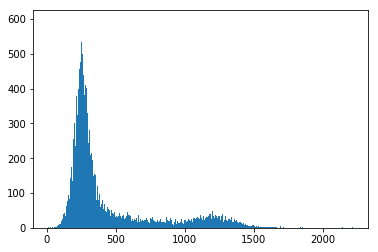

In [16]:
#histogram of the S0 values (b0 image)
x = plt.hist(S0s.ravel(), 500)

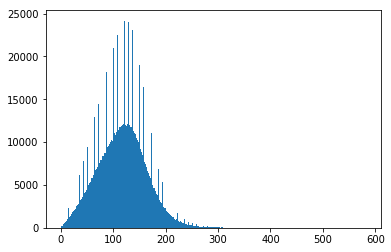

In [17]:
# Histogram of the S_k values
x = plt.hist(data[:, :, :, ~gtab.b0s_mask].ravel(), 500)

The S0 values look nicely bimodal. The S_k values look gaussian with wierd spikes. Are these from eddy currents or head motion?

In [18]:
# Plot z-indices of a 3D volume
def plot_3d_z_indices(vol, idx_list, transpose=True,
                      num_rows=1, num_cols=1, 
                      label_loc_x=5, label_loc_y=5, 
                      im_origin = "lower"):
    """Plot z-index slices of a 3d volume as subplots"""
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(wspace=0.025, hspace=0.0)

    im = None
    for i, idx in enumerate(idx_list):
        plt.subplot(num_rows, num_cols, i+1)
        plt.text(label_loc_x, label_loc_y, str(idx), fontsize=18, 
                 ha="center", color="black",
                 bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        if transpose is True:
            im = plt.imshow(vol[:,:,idx].transpose(), origin=im_origin)
        else:
            im = plt.imshow(vol[:,:,idx], origin=im_origin)

    # now put a color bar on the right
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)


# Single Compartment model

In [19]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

## Fractional Anisotropy

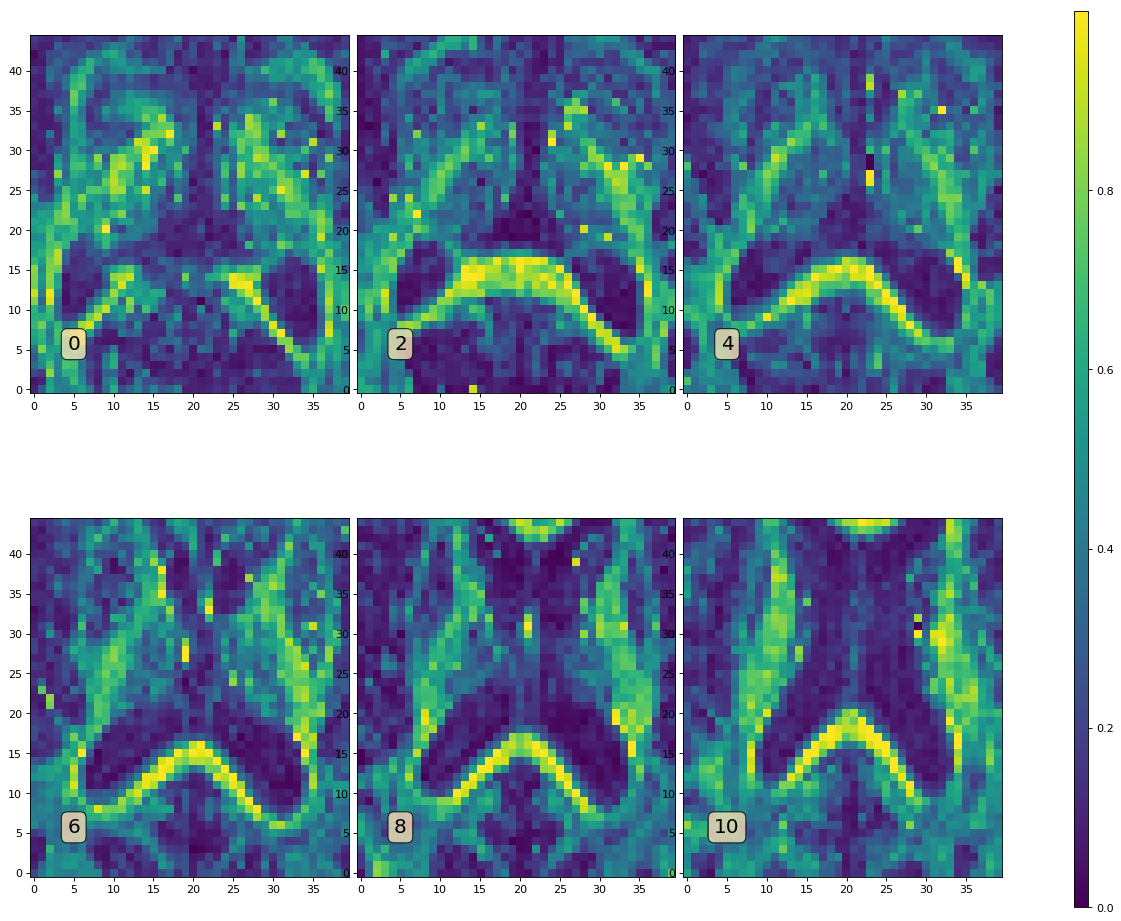

In [20]:
FA = dti.fractional_anisotropy(tenfit.evals)
plot_3d_z_indices(FA, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

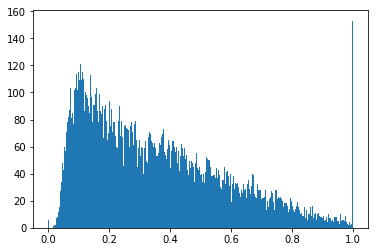

In [21]:
x = plt.hist(FA.ravel(), bins=500)

# Mean Diffusivity

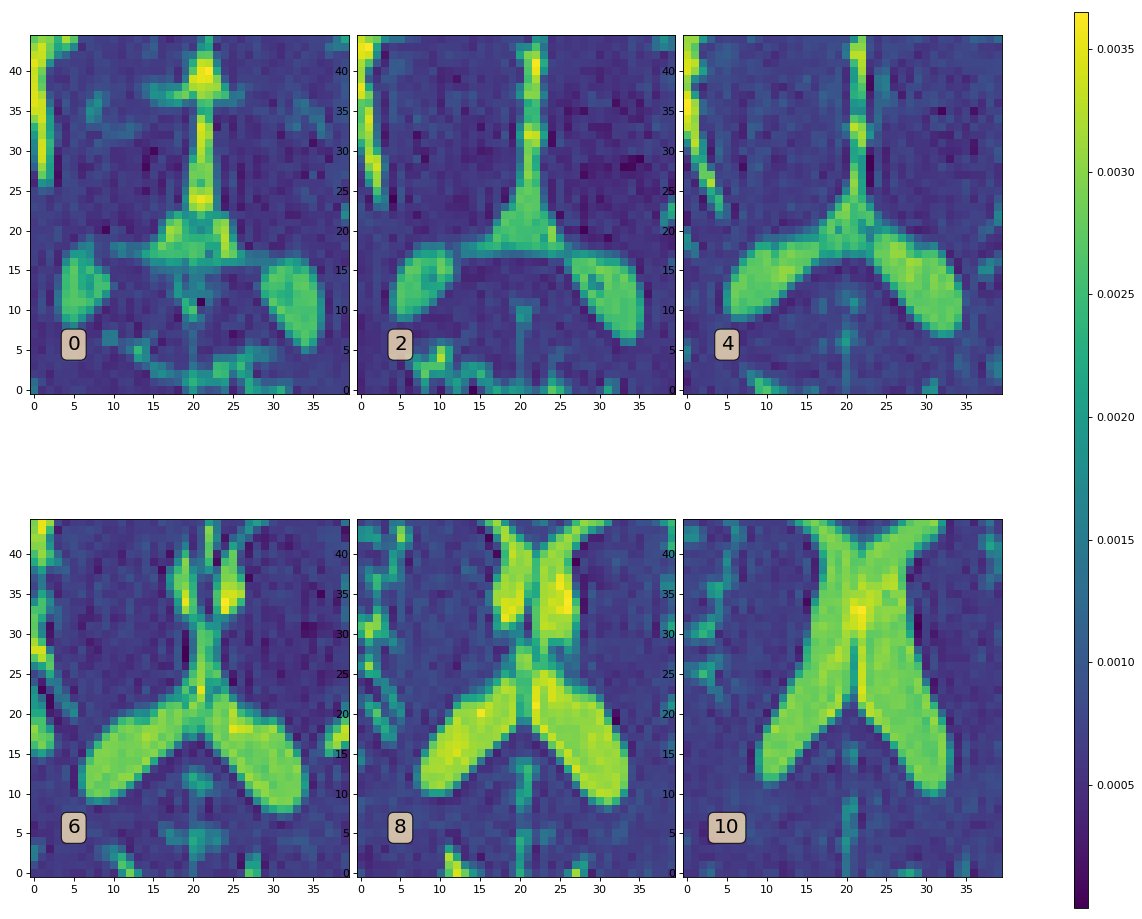

In [22]:
MD1 = dti.mean_diffusivity(tenfit.evals)

# Plot the MD for a few z-indices
plot_3d_z_indices(MD1, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

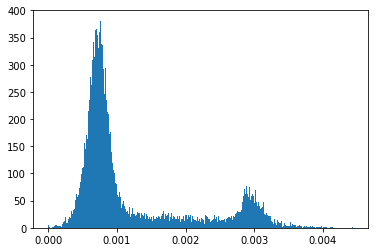

In [23]:
x = plt.hist(MD1.ravel(), bins=500)

# Bi-tensor Model (Free Water)

In [24]:
ADC_water = 3 * 1e-3
b_value = gtab.bvals[1]
Awater_scalar = np.exp(- b_value * ADC_water)
print("Awater_k = %.2f" % Awater_scalar)

Awater_k = 0.05


In [25]:
data_bi = data.astype(np.float_, copy=True)
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]

Make sure there are no zeros in our signal and everything is positive

In [26]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=2216.000000


In [27]:
data_bi[data_bi <= 0] = dti.MIN_POSITIVE_SIGNAL

In [28]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000100, Max=2216.000000


In [29]:
# Attenuations
Ahat = data_bi.copy() # attenuations
Ahat = Ahat / S0s_bi  

In [30]:
max_diffusivity = 5e-3
attenuation_min = np.exp(- b_value * max_diffusivity )

min_diffusivity = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * min_diffusivity)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

Attenuation_min = 0.007, Attenuation_max = 0.990


In [31]:
#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat > attenuation_max] = attenuation_max

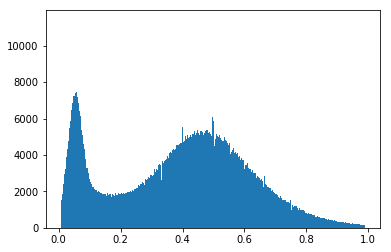

In [32]:
x = plt.hist(Ahat[:,:,:, ~gtab.b0s_mask].ravel(), bins=500)

## Initialization of Free Water Map

Fraction of Data Selected = 0.10


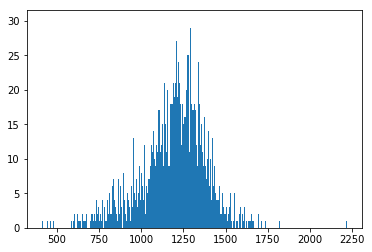

In [33]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD1 - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

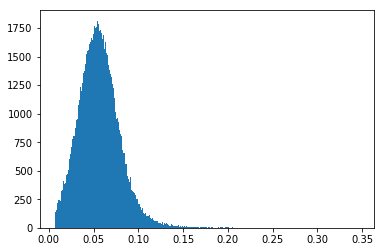

In [34]:
# Lets look at the attentuation when the FA is close to that of water
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [35]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

Fraction of Data Selected = 0.52


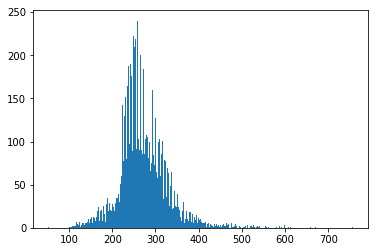

In [36]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD1 - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

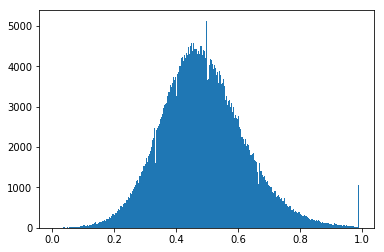

In [37]:
# Lets look at the attentuation when the FA is close to that of 
# white matter 
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [38]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [39]:
#Initial free water map

#looking at the distribution of mean diffusivities we can set
lambda_max = 1 * 1e-3 # max diffusivity in tissue
lambda_min = 0.3 * 1e-3 # min diffusivity in tissue

# Max and min attenuation. (Amax uses lambda_min and vice versa)
Amax = np.exp(-b_value * lambda_min)
Amin = np.exp(-b_value * lambda_max)

print("Amin=%.2f, Amax = %.2f" % (Amin, Amax))

Ahat_min = Ahat[..., ~gtab.b0s_mask].min(axis=3)
Ahat_max = Ahat[...,~gtab.b0s_mask].max(axis=3)

print("Ahat_min.shape = %s" % str(Ahat_min.shape))
print("Ahat_max.shape = %s" % str(Ahat_max.shape))

# Note this formula is perhaps a correction of Equation [6]
fmin = (Ahat_min - Awater_scalar) / (Amax - Awater_scalar)
fmax = (Ahat_max - Awater_scalar) / (Amin - Awater_scalar)

print("fmin.shape = %s" % str(fmin.shape))
print("fmax.shape = %s" % str(fmax.shape))

idx = (20, 25, 6)
print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# now make sure fmax and fmin are between 0 and 1

print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))
fmin[fmin <= 0] = 0.01
fmin[fmin >= 1] = 0.99

print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))
fmax[fmax <= 0] = 0.01
fmax[fmax >= 1] = 0.99
print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))

print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

f_init = 1 - (np.log(np.squeeze(S0s_bi) / Stissue) / np.log(Swater / Stissue))
print("f_init.shape = %s" % str(f_init.shape))
mask = f_init < fmin
f_init[mask] = (fmin[mask] + fmax[mask])/2
mask = f_init > fmax
f_init[mask] = (fmin[mask] + fmax[mask])/2

f_init = f_init[:,:,:,np.newaxis]

# This is our starting value of f
print("f_init.shape = %s" % str(f_init.shape))
print("f_init.max = %.2f, f_init.min=%.2f" % (f_init.max(), f_init.min()))

Amin=0.37, Amax = 0.74
Ahat_min.shape = (40, 45, 12)
Ahat_max.shape = (40, 45, 12)
fmin.shape = (40, 45, 12)
fmax.shape = (40, 45, 12)
Ahat_min=0.02, Ahat_max=0.19, fmax=0.45, fmin=-0.05
fmin.max = 1.16, fmin.min=-0.06
fmax.max = 2.96, fmax.min=-0.05
fmax.max = 1.00, fmax.min=0.00
Ahat_min=0.02, Ahat_max=0.19, fmax=0.45, fmin=0.01
f_init.shape = (40, 45, 12)
f_init.shape = (40, 45, 12, 1)
f_init.max = 0.99, f_init.min=0.01


In [40]:

print("f_init.max = %.2f" % f_init.max())
print("Ahat.max = %.2f" % Ahat.max())

Cwater = (1 - f_init) * Awater_scalar
print("b_value = %.2f" % b_value)
print("Cwater.max = %.2f" % Cwater.max())
print(Cwater.shape)

Ahat_tissue = (Ahat - Cwater) / f_init
print(Ahat_tissue.shape)

#np.unravel_index(Ahat_tissue.argmax(), Ahat_tissue.shape)
#print(Ahat.max())
#print(Ahat_tissue.max())
#print(Ahat_tissue.argmin())

#idx = np.unravel_index(Ahat_tissue.argmin(), Ahat_tissue.shape)
#print(idx)


f_init.max = 0.99
Ahat.max = 0.99
b_value = 1000.00
Cwater.max = 0.05
(40, 45, 12, 1)
(40, 45, 12, 65)


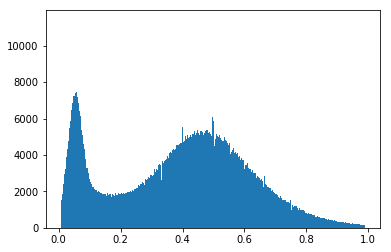

In [41]:
x = plt.hist(Ahat[:,:,:,1:65].ravel(), 500)

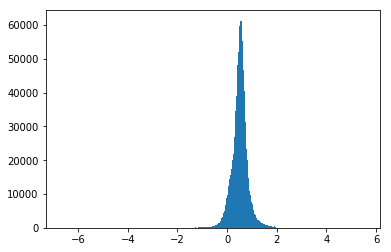

In [42]:
x = plt.hist(Ahat_tissue[:,:,:,1:65].ravel(), 500)

In [43]:
tenmodel_init = dti.TensorModel(gtab)
tenfit_init = tenmodel_init.fit(Ahat_tissue)
FA_init = dti.fractional_anisotropy(tenfit_init.evals)

In [44]:
# This is our starting value of D
tenfit_init.quadratic_form.shape

(40, 45, 12, 3, 3)

In [45]:
tenfit_init.quadratic_form[20, 20, :, 2, 2]

array([0.00249957, 0.00339461, 0.00610208, 0.00650244, 0.00434878,
       0.00485577, 0.00379791, 0.00246082, 0.00195026, 0.00138097,
       0.00037145, 0.00058253])

In [195]:
def create_feature_spatial_manifold(S0, D):
    b0_shape = S0.shape
    d_shape = D.shape
    if (b0_shape[:3] != d_shape[:3]):
        raise ValueError("b0_shape = %s and d_shape = %s." \
                         "The first three dimensions need to match" 
                         % (b0_shape, d_shape))
    manifold_shape = d_shape[:3] + (7,)
    manifold = np.empty(manifold_shape, dtype=D.dtype)
    manifold[...,0] = np.squeeze(S0)
    manifold[...,1] = D[...,0,0]
    manifold[...,2] = D[...,1,1]
    manifold[...,3] = D[...,2,2]
    manifold[...,4] = D[...,0,1] * np.sqrt(2)
    manifold[...,5] = D[...,1,2] * np.sqrt(2)
    manifold[...,6] = D[...,0,2] * np.sqrt(2)
    return(manifold)

manifold = create_feature_spatial_manifold(S0s, tenfit_init.quadratic_form)

In [52]:
beta = 10.
alpha = 1.

In [243]:
qk = gtab.gradients[~gtab.b0s_mask] / b_value

In [ ]:
def dx_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the x-axis"
    dx = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dx[1:,:, :, 0] = manifold[1:, :, :, idx] - manifold[:-1,:, :, idx]
    dx[0, :, :, 0] = 0.
    return(dx)

def dy_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the y-axis"
    dy = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dy[:,1:, :, 0] = manifold[:, 1:, :, idx] - manifold[:, :-1, :, idx]
    dy[:, 0, :, 0] = 0.
    return(dy)

def dz_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the z-axis"
    dz = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dz[:, :,1:, 0] = manifold[:,:, 1:, idx] - manifold[:, :, :-1, idx]
    dz[:, :,0, 0] = 0.
    return(dz)

In [ ]:
def dpx(p):
    """Backwards derivative of the p,q,r vectors wrt x"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:-1, :, :] = p[1:, :, :] - p[:-1, :,:]
    ret[-1, :, :] = 0.
    return(ret)


def dpy(p):
    """Backwards derivative of the p,q,r vectors wrt y"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:, :-1, :] = p[:,1:, :] - p[:, :-1, :]
    ret[:, -1, :] = 0.
    return(ret)

def dpz(p):
    """Backwards derivative of the p,q,r vectors wrt z"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:,:, :-1] = p[:, :, 1:] - p[:, :, :-1]
    ret[:,:, -1] = 0.
    return(ret)

In [264]:
num_iterations = 10
dt = 0.01
f_curr = f_init.copy()
manifold = create_feature_spatial_manifold(S0s, tenfit_init.quadratic_form)

for i in range(num_iterations):
    X4x = dx_manifold(manifold, 1)
    X4y = dy_manifold(manifold, 1)
    X4z = dz_manifold(manifold, 1)

    X5x = dx_manifold(manifold, 2)
    X5y = dy_manifold(manifold, 2)
    X5z = dz_manifold(manifold, 2)

    X6x = dx_manifold(manifold, 3)
    X6y = dy_manifold(manifold, 3)
    X6z = dz_manifold(manifold, 3)

    X7x = dx_manifold(manifold, 4)
    X7y = dy_manifold(manifold, 4)
    X7z = dz_manifold(manifold, 4)

    X8x = dx_manifold(manifold, 5)
    X8y = dy_manifold(manifold, 5)
    X8z = dz_manifold(manifold, 5)

    X9x = dx_manifold(manifold, 6)
    X9y = dy_manifold(manifold, 6)
    X9z = dz_manifold(manifold, 6)

    g11 = np.ones(X4x.shape) + beta * (X4x*X4x + X5x*X5x + X6x*X6x + X7x*X7x + 
                                       X8x*X8x + X9x*X9x)
    g22 = np.ones(X4y.shape) + beta * (X4y*X4y + X5y*X5y + X6y*X6y + X7y*X7y + 
                                       X8y*X8y + X9y*X9y)
    g33 = np.ones(X4z.shape) + beta * (X4z*X4z + X5z*X5z + X6z*X6z + X7z*X7z + 
                                       X8z*X8z + X9z*X9z)
    g12 = beta * (X4x*X4y + X5x*X5y + X6x*X6y + X7x*X7y + X8x*X8y + X9x*X9y)
    g23 = beta * (X4y*X4z + X5y*X5z + X6y*X6z + X7y*X7z + X8y*X8z + X9y*X9z)
    g13 = beta * (X4x*X4z + X5x*X5z + X6x*X6z + X7x*X7z + X8x*X8z + X9x*X9z)

    C11 = g22*g33 - g23*g23
    C22 = g11*g33 - g13*g13
    C33 = g11*g22 - g12*g12
    C12 = -g12*g33 + g13*g23
    C23 = -g11*g23 + g13*g12
    C13 = g12*g23 - g13*g22

    detg = g11*C11 + g12*C12 + g13*C13
    gm05 = 1. / np.sqrt(detg)
    
    #del g11, g22, g33, g12, g23, g13

    p4 = C11*X4x + C12*X4y + C13*X4z
    p5 = C11*X5x + C12*X5y + C13*X5z
    p6 = C11*X6x + C12*X6y + C13*X6z
    p7 = C11*X7x + C12*X7y + C13*X7z
    p8 = C11*X8x + C12*X8y + C13*X8z
    p9 = C11*X9x + C12*X9y + C13*X9z

    q4 = C12*X4x + C22*X4y + C23*X4z
    q5 = C12*X5x + C22*X5y + C23*X5z
    q6 = C12*X6x + C22*X6y + C23*X6z
    q7 = C12*X7x + C22*X7y + C23*X7z
    q8 = C12*X8x + C22*X8y + C23*X8z
    q9 = C12*X9x + C22*X9y + C23*X9z

    r4 = C13*X4x + C23*X4y + C33*X4z
    r5 = C13*X5x + C23*X5y + C33*X5z
    r6 = C13*X6x + C23*X6y + C33*X6z
    r7 = C13*X7x + C23*X7y + C33*X7z
    r8 = C13*X8x + C23*X8y + C33*X8z
    r9 = C13*X9x + C23*X9y + C33*X9z
    
    #del C11, C22, C33, C12, C23, C13

    # Beltrami operator incrementals
    b4inc = dpx(p4 * gm05) + dpy(q4 * gm05) + dpz(r4 * gm05) * np.squeeze(gm05)
    b5inc = dpx(p5 * gm05) + dpy(q5 * gm05) + dpz(r5 * gm05) * np.squeeze(gm05)
    b6inc = dpx(p6 * gm05) + dpy(q6 * gm05) + dpz(r6 * gm05) * np.squeeze(gm05)
    b7inc = dpx(p7 * gm05) + dpy(q7 * gm05) + dpz(r7 * gm05) * np.squeeze(gm05)
    b8inc = dpx(p8 * gm05) + dpy(q8 * gm05) + dpz(r8 * gm05) * np.squeeze(gm05)
    b9inc = dpx(p9 * gm05) + dpy(q9 * gm05) + dpz(r9 * gm05) * np.squeeze(gm05)

    A_bi = Ahat_tissue * f_curr + (1 - f_curr) * Awater_scalar

    fidmat = ((Ahat - A_bi) * Ahat_tissue)[..., ~gtab.b0s_mask]

    fid4inc = (fidmat * (qk[:, 0] * qk[:, 0])).sum(axis=-1)
    fid5inc = (fidmat * (qk[:, 1] * qk[:, 1])).sum(axis=-1)
    fid6inc = (fidmat * (qk[:, 2] * qk[:, 2])).sum(axis=-1)
    fid7inc = (fidmat * (qk[:, 0] * qk[:, 1])).sum(axis=-1) / np.sqrt(2)
    fid8inc = (fidmat * (qk[:, 1] * qk[:, 2])).sum(axis=-1) / np.sqrt(2)
    fid9inc = (fidmat * (qk[:, 0] * qk[:, 2])).sum(axis=-1) / np.sqrt(2)


    #incrementals are the sum of the fidelity incrementals and the beltrami incrementals
    x4inc = b_value * fid4inc + alpha * b4inc
    x5inc = b_value * fid5inc + alpha * b5inc
    x6inc = b_value * fid6inc + alpha * b6inc
    x7inc = b_value * fid7inc + alpha * b7inc
    x8inc = b_value * fid8inc + alpha * b8inc
    x9inc = b_value * fid9inc + alpha * b9inc

    finc = (-b_value) * ((Ahat - A_bi) * (Ahat_tissue - Awater_scalar))[..., ~gtab.b0s_mask].sum(axis=-1)
    
    manifold[...,1] += dt * x4inc
    manifold[...,2] += dt * x5inc
    manifold[...,3] += dt * x6inc
    manifold[...,4] += dt * x7inc
    manifold[...,5] += dt * x8inc
    manifold[...,6] += dt * x9inc
    
    f_curr[...,0] += dt * finc
    
    # make sure that the f values stay constrained
    f_curr = f_curr.squeeze()
    mask = f_curr > fmax
    f_curr[mask] = fmax[mask]
    mask = f_curr < fmin
    f_curr[mask] = fmin[mask]
    
    f_curr = f_curr[...,np.newaxis]
    
     

In [261]:
np.nanmax(x4inc)

10.041557986335055

In [262]:
np.nanmax(fid4inc)

0.01003765855583746

In [263]:
np.nanmax(fidmat)

0.0022682227378770267

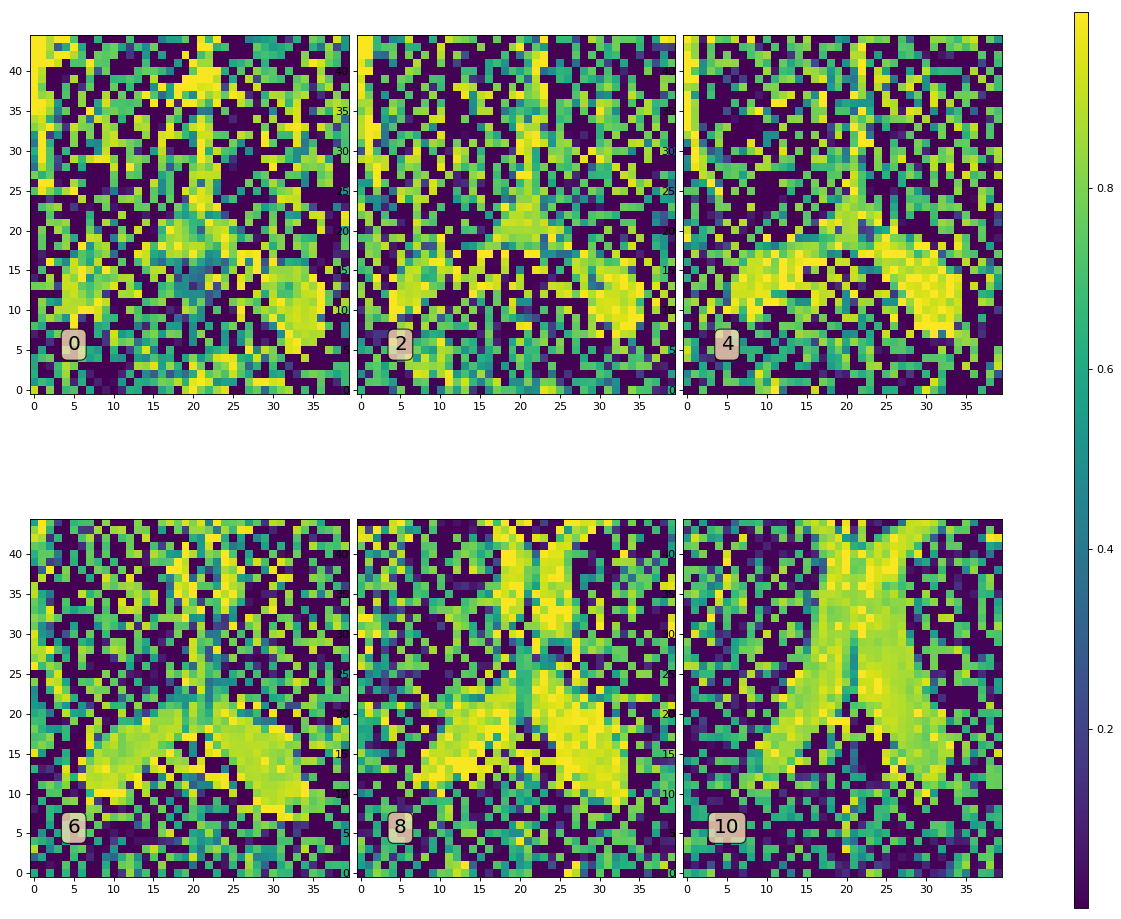

In [265]:
# free water map after iterations
plot_3d_z_indices(1 - f_curr.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

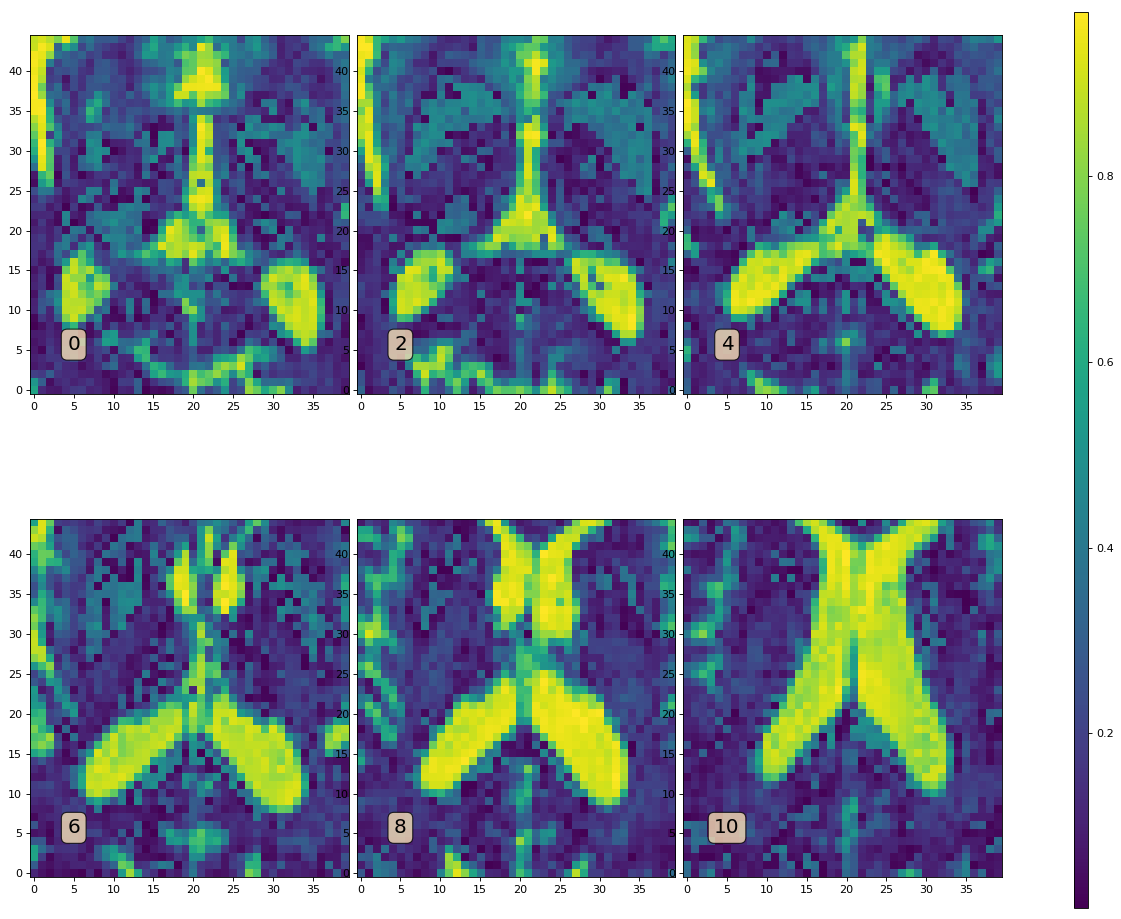

In [254]:
# initial Free water map
plot_3d_z_indices(1 - f_init.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)